# Heisenberg XXX model

$$ H_{\text{TFIM}} = \sum_{j=1}^{L}(X_jX_{j+1}+Y_jY_{j+1}+Z_jZ_{j+1}) $$

pip install qrisp 

https://www.qrisp.eu


In [1]:
import networkx as nx
import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import svds
from qrisp.operators import X, Y, Z
from qrisp import QuantumVariable
from qrisp.vqe.problems.heisenberg import *
from qrisp import QPE

import pickle
from time import time
from datetime import datetime

def save_data(data, filename):  
    # Open a file for writing
    with open(filename+'.pickle', 'wb') as file:
        # Write the object to the file
        pickle.dump(data, file)

def load_data(filename):
    with open(filename+'.pickle', 'rb') as file:
        # Load the object from the file
        data = pickle.load(file)
    return data

## Define Heisenberg Hamiltonian

In [43]:
def create_instance(L, type='Singlet'):

    # Create a graph
    G = nx.Graph()
    G.add_edges_from([(k,k+1) for k in range(L-1)]) 

    def create_heisenberg_hamiltonian(G):
        H = sum(X(i)*X(j)+Y(i)*Y(j)+Z(i)*Z(j) for (i,j) in G.edges())
        return H

    H = create_heisenberg_hamiltonian(G)

    M = H.to_sparse_matrix()
    eigenvalues, eigenvectors = eigsh(M, k=1, which='SA')
    E0 = eigenvalues[0]

    # Rescale to E0=0
    H2 = H - E0

    M = H2.to_sparse_matrix()
    u, s, vt = svds(M, k=1, which='LM')
    spectral_norm = s[0]

    E_max = spectral_norm

    # Rescale such that spectrum in [0,1)
    H3 = H2*(1/(E_max+1))

    M = H3.to_sparse_matrix()
    eigenvalues, eigenvectors = eigsh(M, k=2, which='SA')

    # Ground state
    psi_0 = eigenvectors[:,0]

    E0 = eigenvalues[0]
    E1 = eigenvalues[1]

    delta = E1-E0
    #print('Spectral gap:', delta)
    #print('Ground state energy:', E0)

    if type=='VQE':
        # VQE warm start
        vqe = heisenberg_problem(G,1,0)
        U_0 = vqe.train_function(QuantumVariable(G.number_of_nodes()),depth=1,max_iter=100)

    if type=='Singlet':
        # Tensor product of singlet states
        M = nx.maximal_matching(G)
        U_0 = create_heisenberg_init_function(M)

    qv = QuantumVariable(G.number_of_nodes())
    U_0(qv)

    psi = qv.qs.statevector_array()
    F0 = np.abs(np.dot(psi.conj().transpose(),psi_0))**2
    print('Initial Fidelity', F0)

    return G, H3, U_0, psi_0


# Benchmarking

In [42]:
def prepare_ground_state(precision, steps, G, H, U_0, psi_0, results_dict):

    result = dict()

    qv = QuantumVariable(G.number_of_nodes())
    U_0(qv)

    # Hamiltonian simulation via first order Suzuki-Trotter formula with 5 steps 
    # Note: 5 steps are insufficient to obtain the ground state energy within error 0.1 (10 steps are sufficent)
    exp_H = H.trotterization(order=2,forward_evolution=False)

    qpe_res = QPE(qv,exp_H,precision=precision,kwargs={"t":2*np.pi,"steps":steps},iter_spec=True)

    qc = qpe_res.qs.compile()
    tqc = qc.transpile(basis_gates=["cz","u"])

    result["ops"] = tqc.count_ops()
    result["depth"] = tqc.depth()

    results = qpe_res.get_measurement(precompiled_qc=qc)
    sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))
    #print(sorted_results)
    P0 = sorted_results[0]
    #print('Success probability:', P0)
    result["P0"] = P0

    #qc = qpe_res.qs.compile()

    n = H.find_minimal_qubit_amount()

    for i in range(qc.num_qubits() - n):
        qc.qubits.insert(0, qc.qubits.pop(-1))

    phi = qc.statevector_array()[:2**n]
    phi = phi/np.linalg.norm(phi)

    F0 = (np.abs(np.dot(phi.conj().transpose(),psi_0))**2)
    #print('Fidelity:', F0)
    result["F0"] = F0

    results_dict[precision] = result



In [67]:
def benchmark(L):

    G, H, U_0, psi_0 = create_instance(L, type='Singlet')
    results_dict = dict()
    precision_range = [1,2,3,4,5]
    for precision in precision_range:
        prepare_ground_state(precision, 2, G, H, U_0, psi_0, results_dict)

    return results_dict


In [68]:
benchmark_results = dict()
for L in range(10,22,2):
    res = benchmark(L)
    benchmark_results[L] = res


Initial Fidelity 0.6826139052502765                                                  
Simulating 15 qubits.. |████████████████▍                                    | [ 31%]

KeyboardInterrupt: 

Simulating 15 qubits.. |████████████████▋                                    | [ 32%]

In [ ]:
# Save benchmark data
current_datetime = datetime.now()
date_time_string = current_datetime.strftime("%m-%d-%H")
save_data(benchmark_results,'data_PRL/benchmarks_QPE_Singlet'+date_time_string)

In [ ]:
def run_param_rc(fontsize = 30):
        import matplotlib.pyplot as plt
        plt.rcParams['axes.labelsize'] = fontsize
        plt.rcParams['axes.titlesize'] = fontsize
        plt.rcParams['font.size'] = fontsize
        #set_matplotlib_formats('pdf', 'png')
        plt.rcParams['savefig.dpi'] = 75
        plt.rcParams['lines.linewidth'] = 2.0
        plt.rcParams['lines.markersize'] = 8
        plt.rcParams['legend.fontsize'] = 12
        plt.rcParams['legend.labelspacing'] = .3
        plt.rcParams['legend.columnspacing']= .3
        plt.rcParams['legend.handletextpad']= .1
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = "serif"
        plt.rcParams['font.serif'] = "cm"

run_param_rc(16)

In [75]:
benchmark_results = load_data('data_PRL/benchmarks_QPE_VQE04-25-15')
benchmark_results = load_data('data_PRL/benchmarks_QPE_Singlet04-25-14')

## QPE vs QITE

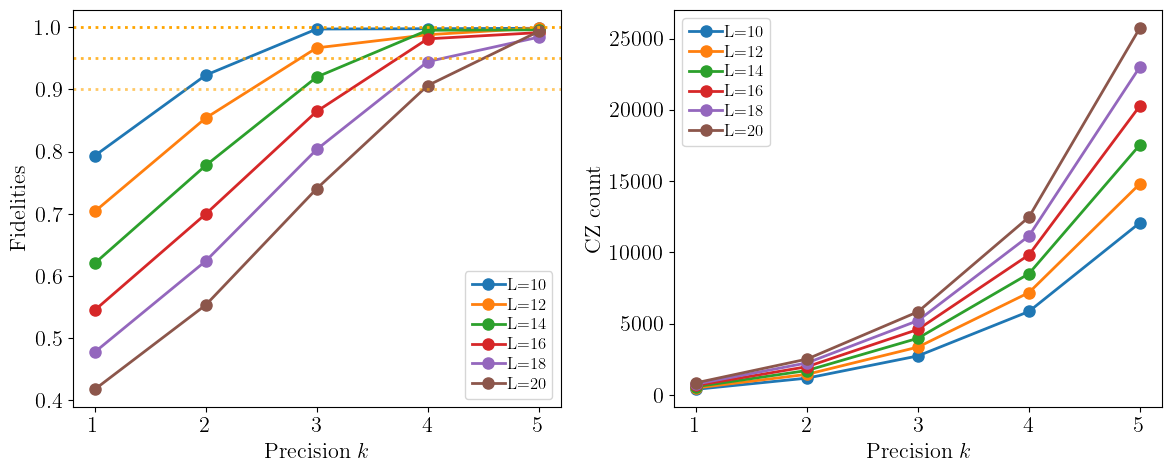

In [76]:
import matplotlib.pyplot as plt

steps = list(range(1,6))

fig, ((axF, axCZ)) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"width_ratios": [1,1]})

for L in range(10,22,2):
    fidelities = [benchmark_results[L][k]['F0'] for k in steps]
    axF.plot(steps, fidelities, marker='o', label=r'L='+str(L))


axF.axhline(y=1, color="orange", linestyle=':', alpha=1.0)
axF.axhline(y=0.95, color="orange", linestyle=':', alpha=0.8)
axF.axhline(y=0.9, color="orange", linestyle=':', alpha=0.6)

axF.legend(loc="best", fontsize=12)
axF.set_xlabel(r"Precision $k$")
axF.set_ylabel(r"Fidelities")

for L in range(10,22,2):
    cz = [benchmark_results[L][k]['ops']['cz'] for k in steps]
    axCZ.plot(steps, cz, marker='o', label=r'L='+str(L))

axCZ.legend(loc="best", fontsize=12)
axCZ.set_xlabel(r"Precision $k$")
axCZ.set_ylabel(r"CZ count")

plt.tight_layout()
plt.savefig("plots_PRL/QPE_Heisenberg_scaling_Singlet.pdf")
plt.show()